# Protein Ligand Complex MD Setup tutorial using BioExcel Building Blocks (biobb)
### Based on the official Gromacs tutorial: http://www.mdtutorials.com/gmx/complex/index.html
***
This tutorial aims to illustrate the process of **setting up a simulation system** containing a **protein in complex with a ligand**, step by step, using the **BioExcel Building Blocks library (biobb)**. The particular example used is the **T4 lysozyme** L99A/M102Q protein (PDB code 3HTB), in complex with the **2-propylphenol** small molecule (3-letter Code JZ4). 
***
**Biobb modules** used:

 - [biobb_io](https://github.com/bioexcel/biobb_io): Tools to fetch biomolecular data from public databases.
 - [biobb_model](https://github.com/bioexcel/biobb_model): Tools to model macromolecular structures.
 - [biobb_chemistry](https://github.com/bioexcel/biobb_chemistry): Tools to manipulate chemical data.
 - [biobb_md](https://github.com/bioexcel/biobb_md): Tools to setup and run Molecular Dynamics simulations.
 - [biobb_analysis](https://github.com/bioexcel/biobb_analysis): Tools to analyse Molecular Dynamics trajectories.
 
**Auxiliar libraries** used:

 - [nglview](http://nglviewer.org/#nglview): Jupyter/IPython widget to interactively view molecular structures and trajectories in notebooks.
 - [ipywidgets](https://github.com/jupyter-widgets/ipywidgets): Interactive HTML widgets for Jupyter notebooks and the IPython kernel.
 - [os](https://docs.python.org/3/library/os.html): Python miscellaneous operating system interfaces
 - [plotly](https://plot.ly/python/offline/): Python interactive graphing library integrated in Jupyter notebooks.
 - [simpletraj](https://github.com/arose/simpletraj): Lightweight coordinate-only trajectory reader based on code from GROMACS, MDAnalysis and VMD.


Conda **Installation**:

 - **conda install -c bioconda biobb_Protein-Ligand_MD_setup**

***
### Pipeline steps:
 1. [Input Parameters](#input)
 2. [Fetching PDB Structure](#fetch)
 3. [Fix Protein Structure](#fix)
 4. [Create Protein System Topology](#top)
 5. [Create ligand system topology](#ligtop)
 6. [Preparing Ligand Restraints](#restraints)
 7. [Create new protein-ligand complex structure file](#complex)
 8. [Create new protein-ligand complex topology file](#complextop)
 9. [Create Solvent Box](#box)
 10. [Fill the Box with Water Molecules](#water)
 11. [Adding Ions](#ions)
 12. [Energetically Minimize the System](#min)
 13. [Equilibrate the System (NVT)](#nvt)
 14. [Equilibrate the System (NPT)](#npt)
 15. [Free Molecular Dynamics Simulation](#free)
 16. [Post-processing and Visualizing Resulting 3D Trajectory](#post)
 17. [Output Files](#output)
 
***
 ***
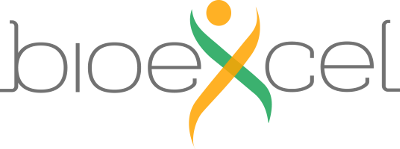
***

<a id="input"></a>
## Input parameters
**Input parameters** needed:
 - **pdbCode**: PDB code of the protein-ligand complex structure (e.g. 3HTB)
 - **ligandCode**: Small molecule 3-letter code for the ligand structure (e.g. JZ4)
 - **mol_charge**: Charge of the small molecule, needed to add hydrogen atoms.

In [1]:
import nglview
import ipywidgets
import os
import zipfile

pdbCode = "3HTB"
ligandCode = "JZ4"
mol_charge = 0

<a id="fetch"></a>
***
## Fetching PDB structure
Downloading **PDB structure** with the **protein-ligand complex** from the RCSB PDB database.<br>
Alternatively, a PDB file can be used as starting structure. <br>
Splitting the molecule in **three different files**: 
- **proteinFile**: Protein structure
- **ligandFile**: Ligand structure
- **complexFile**: Protein-ligand complex structure 

***
**Building Blocks** used:
 - [Pdb](https://biobb-io.readthedocs.io/en/latest/api.html#module-api.pdb) from **biobb_io.api.pdb**
***

In [2]:
# Downloading desired PDB file 
# Import module
from biobb_io.api.pdb import Pdb

# Create properties dict and inputs/outputs
downloaded_pdb = pdbCode+'.orig.pdb'
prop = {
    'pdb_code': pdbCode,
    'filter': False
}

# Create and launch bb
Pdb(output_pdb_path=downloaded_pdb,
    properties=prop).launch()

/home/gbayarri_local/projects/BioBB/biobb_common/biobb_common/tools/file_utils.py:327: UserWarning: Warning: filter is not a recognized property. The most similar property is: filt
  error_property, close_property))
2019-10-16 12:18:01,872 [MainThread  ] [INFO ]  Downloading: 3htb from: https://files.rcsb.org/download/3htb.pdb
2019-10-16 12:18:02,966 [MainThread  ] [INFO ]  Writting pdb to: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB.orig.pdb


In [3]:
# Extracting Protein, Ligand and Protein-Ligand Complex to three different files
# Import module
from biobb_structure_utils.utils.extract_heteroatoms import ExtractHeteroAtoms
from biobb_structure_utils.utils.extract_protein import ExtractProtein
from biobb_structure_utils.utils.cat_pdb import CatPDB

# Create properties dict and inputs/outputs
proteinFile = pdbCode+'.pdb'
ligandFile = ligandCode+'.pdb'
complexFile = pdbCode+'_'+ligandCode+'.pdb'

prop = {
     'heteroatoms' : [{"name": "JZ4"}]
}

ExtractHeteroAtoms(input_structure_path=downloaded_pdb,
     output_heteroatom_path=ligandFile,
     properties=prop).launch()

ExtractProtein(input_structure_path=downloaded_pdb,
     output_protein_path=proteinFile).launch()

CatPDB(input_structure1=proteinFile,
       input_structure2=ligandFile,
       output_structure_path=complexFile).launch()

2019-10-16 12:18:04,882 [MainThread  ] [INFO ]  File JZ4.pdb created
2019-10-16 12:18:04,887 [MainThread  ] [INFO ]  Creating f03b61a2-883b-424b-a2d9-fdda5ff777bf temporary folder
2019-10-16 12:18:05,590 [MainThread  ] [INFO ]  check_structure -i /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB.orig.pdb -o 3HTB.pdb --non_interactive command_list --list f03b61a2-883b-424b-a2d9-fdda5ff777bf/extract_prot.lst

2019-10-16 12:18:05,591 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:05,592 [MainThread  ] [INFO ]  ===============================================================================
=                     MDWeb structure checking utility                        =
=                   A. Hospital, P. Andrio, J.L. Gelpi 2018                   =


Structure /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB.orig.pdb loaded
 Tit

1

### Visualizing 3D structures
Visualizing the generated **PDB structures** using **NGL**:  
- **Protein structure** (Left)
- **Ligand structure** (Center)
- **Protein-ligand complex** (Right)  

In [4]:
# Show structures: protein, ligand and protein-ligand complex
view1 = nglview.show_file(proteinFile)
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_file(ligandFile)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_file(complexFile)
view3.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="fix"></a>
***
## Fix protein structure
**Checking** and **fixing** (if needed) the protein structure:<br>
- **Modeling** **missing side-chain atoms**, modifying incorrect **amide assignments**, choosing **alternative locations**.<br>
- **Checking** for missing **backbone atoms**, **heteroatoms**, **modified residues** and possible **atomic clashes**.

***
**Building Blocks** used:
 - [FixSideChain](https://biobb-model.readthedocs.io/en/latest/model.html#module-model.fix_side_chain) from **biobb_model.model.fix_side_chain**
***

In [5]:
# Check & Fix Protein Structure
# Import module
from biobb_model.model.fix_side_chain import FixSideChain

# Create prop dict and inputs/outputs
fixed_pdb = pdbCode+'_fixed.pdb'

# Create and launch bb
FixSideChain(input_pdb_path=proteinFile,
             output_pdb_path=fixed_pdb).launch()

2019-10-16 12:18:13,450 [MainThread  ] [INFO ]  check_structure -i 3HTB.pdb -o 3HTB_fixed.pdb --force_save fixside --fix ALL

2019-10-16 12:18:13,452 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:13,453 [MainThread  ] [INFO ]  ===============================================================================
=                     MDWeb structure checking utility                        =
=                   A. Hospital, P. Andrio, J.L. Gelpi 2018                   =


Structure 3HTB.pdb loaded
 Title: 
 Experimental method: unknown
 Resolution: 0.0 A

 Num. models: 1
 Num. chains: 1 (A: Protein)
 Num. residues:  163
 Num. residues with ins. codes:  0
 Num. HETATM residues:  0
 Num. ligands or modified residues:  0
 Num. water mol.:  0
 Num. atoms:  1300

Running fixside. Options: --fix ALL 
No residues with missing side chain atoms found
Structure not modified, saving due to --force_save option
Final Num. models: 1
Final Num. chains: 1 (A: Protein)
Final Num. residues:  163
Final N

0

<a id="top"></a>
***
## Create protein system topology
**Building GROMACS topology** corresponding to the protein structure.<br>
Force field used in this tutorial is [**amber99sb-ildn**](https://dx.doi.org/10.1002%2Fprot.22711): AMBER **parm99** force field with **corrections on backbone** (sb) and **side-chain torsion potentials** (ildn). Water molecules type used in this tutorial is [**spc/e**](https://pubs.acs.org/doi/abs/10.1021/j100308a038).<br>
Adding **hydrogen atoms** if missing. Automatically identifying **disulfide bridges**. <br>

Generating two output files: 
- **GROMACS structure** (gro file)
- **GROMACS topology** ZIP compressed file containing:
    - *GROMACS topology top file* (top file)
    - *GROMACS position restraint file/s* (itp file/s)
***
**Building Blocks** used:
 - [Pdb2gmx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.pdb2gmx) from **biobb_md.gromacs.pdb2gmx**
***

In [6]:
# Create Protein system topology
# Import module
from biobb_md.gromacs.pdb2gmx import Pdb2gmx

# Create inputs/outputs
output_pdb2gmx_gro = pdbCode+'_pdb2gmx.gro'
output_pdb2gmx_top_zip = pdbCode+'_pdb2gmx_top.zip'
prop = {
    'force_field' : 'amber99sb-ildn',
    'water_type': 'spce'
}

# Create and launch bb
Pdb2gmx(input_pdb_path=fixed_pdb,
        output_gro_path=output_pdb2gmx_gro,
        output_top_zip_path=output_pdb2gmx_top_zip,
        properties=prop).launch()

2019-10-16 12:18:16,278 [MainThread  ] [INFO ]  GROMACS Pdb2gmx 20191 version detected
2019-10-16 12:18:16,876 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright pdb2gmx -f 3HTB_fixed.pdb -o 3HTB_pdb2gmx.gro -p p2g.top -water spce -ff amber99sb-ildn -i posre.itp

2019-10-16 12:18:16,877 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:16,878 [MainThread  ] [INFO ]  
Using the Amber99sb-ildn force field in directory amber99sb-ildn.ff

going to rename amber99sb-ildn.ff/aminoacids.r2b
going to rename amber99sb-ildn.ff/dna.r2b
going to rename amber99sb-ildn.ff/rna.r2b
Reading 3HTB_fixed.pdb...
Read '', 1364 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 163 residues with 1364 atoms

  chain  #res #atoms
  1 'A'   163   1364  

Reading residue database... (Amber99sb-ildn)
Processing chain 1 'A' (1364 atoms, 163 residues)
Identified residue MET1 as a starting terminus.
Identified residue ASN163 a

0

<a id="ligtop"></a>
***
## Create ligand system topology
**Building GROMACS topology** corresponding to the ligand structure.<br>
Force field used in this tutorial step is **amberGAFF**: [General AMBER Force Field](http://ambermd.org/antechamber/gaff.html), designed for rational drug design.<br>
- [Step 1](#ligandTopologyStep1): Add **hydrogen atoms** if missing.
- [Step 2](#ligandTopologyStep2): **Energetically minimize the system** with the new hydrogen atoms. 
- [Step 3](#ligandTopologyStep3): Generate **ligand topology** (parameters). 
***
**Building Blocks** used:
 - [ReduceAddHydrogens](https://biobb-chemistry.readthedocs.io/en/latest/ambertools.html#module-ambertools.reduce_add_hydrogens) from **biobb_chemistry.ambertools.reduce_add_hydrogens**
 - [BabelMinimize](https://biobb-chemistry.readthedocs.io/en/latest/babelm.html#module-babelm.babel_minimize) from **biobb_chemistry.babelm.babel_minimize** 
 - [AcpypeParamsGMX](https://biobb-chemistry.readthedocs.io/en/latest/acpype.html#module-acpype.acpype_params_gmx) from **biobb_chemistry.acpype.acpype_params_gmx** 
***

<a id="ligandTopologyStep1"></a>
### Step 1: Add **hydrogen atoms**

In [7]:
# Create Ligand system topology, STEP 1
# Reduce_add_hydrogens: add Hydrogen atoms to a small molecule (using Reduce tool from Ambertools package)
# Import module
from biobb_chemistry.ambertools.reduce_add_hydrogens import ReduceAddHydrogens

# Create prop dict and inputs/outputs
output_reduce_h = ligandCode+'.reduce.H.pdb' 
prop = {
    'nuclear' : 'true'
}

# Create and launch bb
ReduceAddHydrogens(input_path=ligandFile,
                   output_path=output_reduce_h,
                   properties=prop).launch()


2019-10-16 12:18:19,602 [MainThread  ] [INFO ]  reduce -NUClear -OH -ROTNH3 -ALLALT JZ4.pdb > JZ4.reduce.H.pdb

2019-10-16 12:18:19,604 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:19,605 [MainThread  ] [INFO ]  reduce: version 3.3 06/02/2016, Copyright 1997-2016, J. Michael Word
Processing file: "JZ4.pdb"
Database of HETATM connections: "/anaconda3/envs/biobb_dev/dat/reduce_wwPDB_het_dict.txt"
VDW dot density = 16/A^2
Orientation penalty scale = 1 (100%)
Eliminate contacts within 3 bonds.
Ignore atoms with |occupancy| <= 0.01 during adjustments.
Waters ignored if B-Factor >= 40 or |occupancy| < 0.66
Aromatic rings in amino acids accept hydrogen bonds.
Building or keeping OH & SH Hydrogens.
Rotating NH3 Hydrogens.
Not processing Met methyls.
 Singles(size 1): A 167 JZ4 OAB 
 orientation 1: A 167 JZ4 OAB :   rot  120: bump=0.000, HB=0.000, total=0.000
Found 0 hydrogens (0 hets)
Standardized 0 hydrogens (0 hets)
Added 12 hydrogens (12 hets)
Removed 0 hydrogens (0 hets)
Adjusted 

0

<a id="ligandTopologyStep2"></a>
### Step 2: **Energetically minimize the system** with the new hydrogen atoms. 

In [8]:
# Create Ligand system topology, STEP 2
# Babel_minimize: Structure energy minimization of a small molecule after being modified adding hydrogen atoms
# Import module
from biobb_chemistry.babelm.babel_minimize import BabelMinimize

# Create prop dict and inputs/outputs
output_babel_min = ligandCode+'.H.min.mol2'                              
prop = {
    'method' : 'sd',
    'criteria' : '1e-10',
    'force_field' : 'GAFF'
}


# Create and launch bb
BabelMinimize(input_path=output_reduce_h,
              output_path=output_babel_min,
              properties=prop).launch()

2019-10-16 12:18:22,182 [MainThread  ] [INFO ]  Hydrogens  is not correct, assigned default value: False
2019-10-16 12:18:22,184 [MainThread  ] [INFO ]  Steps  is not correct, assigned default value: 2500
2019-10-16 12:18:22,185 [MainThread  ] [INFO ]  Cut-off  is not correct, assigned default value: False
2019-10-16 12:18:22,186 [MainThread  ] [INFO ]  Rvdw  is not correct, assigned default value: 6.0
2019-10-16 12:18:22,188 [MainThread  ] [INFO ]  Rele  is not correct, assigned default value: 10.0
2019-10-16 12:18:22,189 [MainThread  ] [INFO ]  Frequency  is not correct, assigned default value: 10
2019-10-16 12:18:22,815 [MainThread  ] [INFO ]  obminimize -c 1e-10 -sd -ff GAFF -ipdb JZ4.reduce.H.pdb -omol2 > JZ4.H.min.mol2

2019-10-16 12:18:22,816 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:22,817 [MainThread  ] [INFO ]  
A T O M   T Y P E S

IDX	TYPE	RING
1	c3	NO
2	ca	AR
3	ca	AR
4	ca	AR
5	ca	AR
6	ca	AR
7	ca	AR
8	c3	NO
9	c3	NO
10	oh	NO
11	ho	NO
12	hc	NO
13	hc	NO
14	ha	NO
15

0

### Visualizing 3D structures
Visualizing the small molecule generated **PDB structures** using **NGL**:  
- **Original Ligand Structure** (Left)
- **Ligand Structure with hydrogen atoms added** (with Reduce program) (Center)
- **Ligand Structure with hydrogen atoms added** (with Reduce program), **energy minimized** (with Open Babel) (Right) 

In [9]:
# Show different structures generated (for comparison)

view1 = nglview.show_file(ligandFile)
view1.add_representation(repr_type='ball+stick')
view1._remote_call('setSize', target='Widget', args=['350px','400px'])
view1.camera='orthographic'
view1
view2 = nglview.show_file(output_reduce_h)
view2.add_representation(repr_type='ball+stick')
view2._remote_call('setSize', target='Widget', args=['350px','400px'])
view2.camera='orthographic'
view2
view3 = nglview.show_file(output_babel_min)
view3.add_representation(repr_type='ball+stick')
view3._remote_call('setSize', target='Widget', args=['350px','400px'])
view3.camera='orthographic'
view3
ipywidgets.HBox([view1, view2, view3])

<a id="ligandTopologyStep3"></a>
### Step 3: Generate **ligand topology** (parameters).

In [10]:
# Create Ligand system topology, STEP 3
# Acpype_params_gmx: Generation of topologies for GROMACS with ACPype
# Import module
from biobb_chemistry.acpype.acpype_params_gmx import AcpypeParamsGMX

# Create prop dict and inputs/outputs
output_acpype_gro = ligandCode+'params.gro'
output_acpype_itp = ligandCode+'params.itp'
output_acpype_top = ligandCode+'params.top'
output_acpype = ligandCode+'params'
prop = {
    'basename' : output_acpype,
    'charge' : mol_charge
}

# Create and launch bb
AcpypeParamsGMX(input_path=output_babel_min, 
                output_path_gro=output_acpype_gro,
                output_path_itp=output_acpype_itp,
                output_path_top=output_acpype_top,
                properties=prop).launch()

2019-10-16 12:18:26,814 [MainThread  ] [INFO ]  Running acpype, this execution can take a while
2019-10-16 12:18:28,820 [MainThread  ] [INFO ]  acpype -i /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/JZ4.H.min.mol2 -b JZ4params.d2F0h2 -n 0

2019-10-16 12:18:28,821 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:28,822 [MainThread  ] [INFO ]  ========================================================================================
| ACPYPE: AnteChamber PYthon Parser interfacE v. 2018-04-24T22:34:57UTC (c) 2019 AWSdS |
==> ... charge set to 0
==> Executing Antechamber...
==> * Antechamber OK *
==> * Parmchk OK *
==> Executing Tleap...
++++++++++start_quote+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
Checking 'JZ4'....
Checking parameters for unit 'JZ4'.
Checking for bond parameters.
Checking for angle parameters.
Unit is OK.
++++++++++end_quote++++++++++++++++++++++++++++++++++++++++++++++++

0

<a id="restraints"></a>
***
## Preparing Ligand Restraints
In subsequent steps of the pipeline, such as the equilibration stages of the **protein-ligand complex** system, it is recommended to apply some **restraints** to the small molecule, to avoid a possible change in position due to protein repulsion. **Position restraints** will be applied to the ligand, using a **force constant of 1000 KJ/mol\*nm^2** on the three coordinates: x, y and z. In this steps the **restriction files** will be created and integrated in the **ligand topology**.
- [Step 1](#restraintsStep1): Creating an index file with a new group including just the **small molecule heavy atoms**.
- [Step 2](#restraintsStep2): Generating the **position restraints** file.
***
**Building Blocks** used:
 - [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_md.gromacs.make_ndx** 
 - [Genrestr](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genrestr) from **biobb_md.gromacs.genrestr** 
***

<a id="restraintsStep1"></a>
### Step 1: Creating an index file for the small molecule heavy atoms

In [11]:
# MakeNdx: Creating index file with a new group (small molecule heavy atoms)
from biobb_md.gromacs.make_ndx import MakeNdx

# Create prop dict and inputs/outputs
output_ligand_ndx = ligandCode+'_index.ndx'
prop = {
    'selection': "0 & ! a H*"
}

# Create and launch bb
MakeNdx(input_structure_path=output_acpype_gro,
        output_ndx_path=output_ligand_ndx,
        properties=prop).launch()

2019-10-16 12:18:31,338 [MainThread  ] [INFO ]  GROMACS MakeNdx 20191 version detected
2019-10-16 12:18:31,354 [MainThread  ] [INFO ]  echo "0 & ! a H* 
 q" | gmx -nobackup -nocopyright make_ndx -f JZ4params.gro -o JZ4_index.ndx

2019-10-16 12:18:31,356 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:31,357 [MainThread  ] [INFO ]  Going to read 0 old index file(s)
Analysing residue names:
There are:     1      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              :    22 atoms
  1 Other               :    22 atoms
  2 JZ4                 :    22 atoms

 nr : group      '!': not  'name' nr name   'splitch' nr    Enter: list groups
 'a': atom       '&': and  'del' nr         'splitres' nr   'l': list residues
 't': atom type  '|': or   'keep' nr        'splitat' nr    'h': help
 'r': residue              'res' nr         'chain' char
 "name": group             'case': case sensitive           'q': save and qu

0

<a id="restraintsStep2"></a>
### Step 2: Generating the position restraints file

In [12]:
# Genrestr: Generating the position restraints file
from biobb_md.gromacs.genrestr import Genrestr

# Create prop dict and inputs/outputs
output_restraints_top = ligandCode+'_posres.itp'
prop = {
    'force_constants': "1000 1000 1000",
    'restrained_group': "System"
}

# Create and launch bb
Genrestr(input_structure_path=output_acpype_gro,
         input_ndx_path=output_ligand_ndx,
         output_itp_path=output_restraints_top,
         properties=prop).launch()

2019-10-16 12:18:33,326 [MainThread  ] [INFO ]  GROMACS Genrestr 20191 version detected
2019-10-16 12:18:33,339 [MainThread  ] [INFO ]  echo "System" | gmx -nobackup -nocopyright genrestr -f JZ4params.gro -n JZ4_index.ndx -o JZ4_posres.itp -fc 1000 1000 1000

2019-10-16 12:18:33,341 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:33,342 [MainThread  ] [INFO ]  Select group to position restrain
Selected 0: 'System'

2019-10-16 12:18:33,344 [MainThread  ] [INFO ]                       :-) GROMACS - gmx genrestr, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright genrestr -f JZ4params.gro -n JZ4_index.ndx -o JZ4_posres.itp -fc 1000 1000 1000


Reading structure file
Group     0 (         System) has    22 elements
Group     1 (          Other) has    22 ele

0

<a id="complex"></a>
***
## Create new protein-ligand complex structure file
Building new **protein-ligand complex** PDB file with:
- The new **protein system** with fixed problems from *Fix Protein Structure* step and hydrogens atoms added from *Create Protein System Topology* step.
- The new **ligand system** with hydrogens atoms added from *Create Ligand System Topology* step. 

This new structure is needed for **GROMACS** as it is **force field-compliant**, it **has all the new hydrogen atoms**, and the **atom names are matching the newly generated protein and ligand topologies**.
***
**Building Blocks** used:
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str**
***

In [13]:
# biobb analysis module
from biobb_analysis.gromacs.gmx_trjconv_str import GMXTrjConvStr
from biobb_structure_utils.utils.cat_pdb import CatPDB

# Convert gro (with hydrogens) to pdb (PROTEIN)
proteinFile_H = pdbCode+'_'+ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_pdb2gmx_gro,
              input_top_path=output_pdb2gmx_gro,
              output_str_path=proteinFile_H, 
              properties=prop).launch()

# Convert gro (with hydrogens) to pdb (LIGAND)
ligandFile_H = ligandCode+'_complex_H.pdb'
prop = {
    'selection' : 'System'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_acpype_gro,
              input_top_path=output_acpype_gro,
              output_str_path=ligandFile_H, 
              properties=prop).launch()


# Concatenating both PDB files: Protein + Ligand
complexFile_H = pdbCode+'_'+ligandCode+'_H.pdb'

# Create and launch bb
CatPDB(input_structure1=proteinFile_H,
       input_structure2=ligandFile_H,
       output_structure_path=complexFile_H).launch()

2019-10-16 12:18:35,381 [MainThread  ] [INFO ]  echo "System" | gmx trjconv -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx.gro -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx.gro -o 3HTB_JZ4_complex_H.pdb

2019-10-16 12:18:35,383 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:35,384 [MainThread  ] [INFO ]  Note that major changes are planned in future for trjconv, to improve usability and utility.Select group for output
Selected 0: 'System'

2019-10-16 12:18:35,385 [MainThread  ] [INFO ]                       :-) GROMACS - gmx trjconv, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton

1

<a id="complextop"></a>
***
## Create new protein-ligand complex topology file
Building new **protein-ligand complex** GROMACS topology file with:
- The new **protein system** topology generated from *Create Protein System Topology* step.
- The new **ligand system** topology generated from *Create Ligand System Topology* step. 

NOTE: From this point on, the **protein-ligand complex structure and topology** generated can be used in a regular MD setup.
***
**Building Blocks** used:
 - [AppendLigand](https://biobb-md.readthedocs.io/en/latest/modules.html) from **biobb_md.gromacs_extra.append_ligand**  (NOTE: link should be updated with the documentation)
***

In [14]:
# AppendLigand: Append a ligand to a GROMACS topology
# Import module
from biobb_md.gromacs_extra.append_ligand import AppendLigand

# Create prop dict and inputs/outputs
output_complex_top = pdbCode+'_'+ligandCode+'_complex.top.zip'

posresifdef = "POSRES_"+ligandCode.upper()
prop = {
    'posres_name': posresifdef
}

# Create and launch bb
AppendLigand(input_top_zip_path=output_pdb2gmx_top_zip,
             input_posres_itp_path=output_restraints_top,
             input_itp_path=output_acpype_itp, 
             output_top_zip_path=output_complex_top,
             properties=prop).launch()

2019-10-16 12:18:37,053 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_pdb2gmx_top.zip
2019-10-16 12:18:37,055 [MainThread  ] [INFO ]  to:
2019-10-16 12:18:37,056 [MainThread  ] [INFO ]  ['2f1bad50-8013-4b63-b9dd-8ec680ebc5c3/p2g.top', '2f1bad50-8013-4b63-b9dd-8ec680ebc5c3/posre.itp']
2019-10-16 12:18:37,058 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:18:37,059 [MainThread  ] [INFO ]  3HTB_pdb2gmx_top.zip
2019-10-16 12:18:37,060 [MainThread  ] [INFO ]  To: 
2019-10-16 12:18:37,061 [MainThread  ] [INFO ]  2f1bad50-8013-4b63-b9dd-8ec680ebc5c3/p2g.top
2019-10-16 12:18:37,062 [MainThread  ] [INFO ]  2f1bad50-8013-4b63-b9dd-8ec680ebc5c3/posre.itp
2019-10-16 12:18:37,105 [MainThread  ] [INFO ]  Compressing topology to: 3HTB_JZ4_complex.top.zip
2019-10-16 12:18:37,106 [MainThread  ] [INFO ]  Ignored file 2f1bad50-8013-4b63-b9dd-8ec680ebc5c3/amber99sb-ildn.ff/forcefield.i

 JZ4params 3



0

<a id="box"></a>
***
## Create solvent box
Define the unit cell for the **protein-ligand complex** to fill it with water molecules.<br>
**Truncated octahedron** box is used for the unit cell. This box type is the one which best reflects the geometry of the solute/protein, in this case a **globular protein**, as it approximates a sphere. It is also convenient for the computational point of view, as it accumulates **less water molecules at the corners**, reducing the final number of water molecules in the system and making the simulation run faster.<br> A **protein to box** distance of **0.8 nm** is used, and the protein is **centered in the box**.  

***
**Building Blocks** used:
 - [Editconf](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.editconf) from **biobb_md.gromacs.editconf** 
***

In [15]:
# Editconf: Create solvent box
# Import module
from biobb_md.gromacs.editconf import Editconf

# Create prop dict and inputs/outputs
output_editconf_gro = pdbCode+'_'+ligandCode+'_complex_editconf.gro'

prop = {
    'box_type': 'octahedron',
    'distance_to_molecule': 0.8
}

# Create and launch bb
Editconf(input_gro_path=complexFile_H, 
         output_gro_path=output_editconf_gro,
         properties=prop).launch()

2019-10-16 12:18:38,697 [MainThread  ] [INFO ]  GROMACS Editconf 20191 version detected
2019-10-16 12:18:38,698 [MainThread  ] [INFO ]  Centering molecule in the box.
2019-10-16 12:18:38,699 [MainThread  ] [INFO ]  Distance of the box to molecule:   0.80
2019-10-16 12:18:38,700 [MainThread  ] [INFO ]  Box type: octahedron
2019-10-16 12:18:38,759 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright editconf -f 3HTB_JZ4_H.pdb -o 3HTB_JZ4_complex_editconf.gro -d 0.8 -bt octahedron -c

2019-10-16 12:18:38,761 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:18:38,761 [MainThread  ] [INFO ]  Note that major changes are planned in future for editconf, to improve usability and utility.Read 2636 atoms
Volume: 1322.64 nm^3, corresponds to roughly 595100 electrons
No velocities found
    system size :  4.069  4.192  5.073 (nm)
    diameter    :  5.849               (nm)
    center      :  2.241 -1.669 -0.935 (nm)
    box vectors :  8.398 10.808 14.572 (nm)
    box angles  :  90.00  90.00  90.00 

0

<a id="water"></a>
***
## Fill the box with water molecules
Fill the unit cell for the **protein-ligand complex** with water molecules.<br>
The solvent type used is the default **Simple Point Charge water (SPC)**, a generic equilibrated 3-point solvent model. 

***
**Building Blocks** used:
 - [Solvate](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.solvate) from **biobb_md.gromacs.solvate** 
***

In [16]:
# Solvate: Fill the box with water molecules
from biobb_md.gromacs.solvate import Solvate

# Create prop dict and inputs/outputs
output_solvate_gro = pdbCode+'_'+ligandCode+'_solvate.gro'
output_solvate_top_zip = pdbCode+'_'+ligandCode+'_solvate_top.zip'

# Create and launch bb
Solvate(input_solute_gro_path=output_editconf_gro,
        output_gro_path=output_solvate_gro,
        input_top_zip_path=output_complex_top,
        output_top_zip_path=output_solvate_top_zip).launch()

2019-10-16 12:18:40,457 [MainThread  ] [INFO ]  GROMACS Solvate 20191 version detected
2019-10-16 12:18:40,462 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_complex.top.zip
2019-10-16 12:18:40,463 [MainThread  ] [INFO ]  to:
2019-10-16 12:18:40,464 [MainThread  ] [INFO ]  ['e44cd738-f6e7-4ebc-bd39-b926c5819601/JZ4_posres.itp', 'e44cd738-f6e7-4ebc-bd39-b926c5819601/JZ4params.itp', 'e44cd738-f6e7-4ebc-bd39-b926c5819601/ligand.top', 'e44cd738-f6e7-4ebc-bd39-b926c5819601/posre.itp']
2019-10-16 12:18:40,464 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:18:40,466 [MainThread  ] [INFO ]  3HTB_JZ4_complex.top.zip
2019-10-16 12:18:40,466 [MainThread  ] [INFO ]  To: 
2019-10-16 12:18:40,467 [MainThread  ] [INFO ]  e44cd738-f6e7-4ebc-bd39-b926c5819601/JZ4_posres.itp
2019-10-16 12:18:40,468 [MainThread  ] [INFO ]  e44cd738-f6e7-4ebc-bd39-b926c5819601/JZ4params.itp
2019-10-

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **solvent box** using **NGL**<br>
Note the **octahedral box** filled with **water molecules** surrounding the **protein structure**, which is **centered** right in the middle of the box.

In [17]:
#Show protein
view = nglview.show_file(output_solvate_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='line', linewidth='1', selection='SOL', opacity='.3')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="ions"></a>
***
## Adding ions
Add ions to neutralize the **protein-ligand complex** and reach a desired ionic concentration.
- [Step 1](#ionsStep1): Creating portable binary run file for ion generation
- [Step 2](#ionsStep2): Adding ions to **neutralize** the system and reach a **0.05 molar ionic concentration**
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Genion](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.genion) from **biobb_md.gromacs.genion** 
***

<a id="ionsStep1"></a>
### Step 1: Creating portable binary run file for ion generation

In [18]:
# Grompp: Creating portable binary run file for ion generation
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'minimization',
        'nsteps':'5000'
    }
}
output_gppion_tpr = pdbCode+'_'+ligandCode+'_complex_gppion.tpr'

# Create and launch bb
Grompp(input_gro_path=output_solvate_gro,
       input_top_zip_path=output_solvate_top_zip, 
       output_tpr_path=output_gppion_tpr,
       properties=prop).launch()

2019-10-16 12:18:46,830 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2019-10-16 12:18:46,832 [MainThread  ] [INFO ]  Will run a minimization md of 5000 steps
2019-10-16 12:18:46,836 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_solvate_top.zip
2019-10-16 12:18:46,837 [MainThread  ] [INFO ]  to:
2019-10-16 12:18:46,838 [MainThread  ] [INFO ]  ['b36ad09b-f7c4-498f-9bc1-3a7320c2d431/JZ4_posres.itp', 'b36ad09b-f7c4-498f-9bc1-3a7320c2d431/JZ4params.itp', 'b36ad09b-f7c4-498f-9bc1-3a7320c2d431/ligand.top', 'b36ad09b-f7c4-498f-9bc1-3a7320c2d431/posre.itp']
2019-10-16 12:18:46,840 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:18:46,841 [MainThread  ] [INFO ]  3HTB_JZ4_solvate_top.zip
2019-10-16 12:18:46,841 [MainThread  ] [INFO ]  To: 
2019-10-16 12:18:46,842 [MainThread  ] [INFO ]  b36ad09b-f7c4-498f-9bc1-3a7320c2d431/JZ4_posres.itp
2019-10-16 12:18:46

0

<a id="ionsStep2"></a>
### Step 2: Adding ions to neutralize the system and reach a 0.05 molar concentration
Replace **solvent molecules** with **ions** to **neutralize** the system and reaching a **0.05 molar ionic concentration**

In [19]:
# Genion: Adding ions to reach a 0.05 molar concentration
from biobb_md.gromacs.genion import Genion

# Create prop dict and inputs/outputs
prop={
    'neutral':True,
    'concentration':0.05
}
output_genion_gro = pdbCode+'_'+ligandCode+'_genion.gro'
output_genion_top_zip = pdbCode+'_'+ligandCode+'_genion_top.zip'

# Create and launch bb
Genion(input_tpr_path=output_gppion_tpr,
       output_gro_path=output_genion_gro, 
       input_top_zip_path=output_solvate_top_zip,
       output_top_zip_path=output_genion_top_zip, 
       properties=prop).launch()

2019-10-16 12:18:49,533 [MainThread  ] [INFO ]  GROMACS Genion 20191 version detected
2019-10-16 12:18:49,534 [MainThread  ] [INFO ]  To reach up 0.05 mol/litre concentration
2019-10-16 12:18:49,540 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_solvate_top.zip
2019-10-16 12:18:49,541 [MainThread  ] [INFO ]  to:
2019-10-16 12:18:49,542 [MainThread  ] [INFO ]  ['69ab5118-3f07-4023-a0f7-b7d244222e3f/JZ4_posres.itp', '69ab5118-3f07-4023-a0f7-b7d244222e3f/JZ4params.itp', '69ab5118-3f07-4023-a0f7-b7d244222e3f/ligand.top', '69ab5118-3f07-4023-a0f7-b7d244222e3f/posre.itp']
2019-10-16 12:18:49,543 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:18:49,545 [MainThread  ] [INFO ]  3HTB_JZ4_solvate_top.zip
2019-10-16 12:18:49,546 [MainThread  ] [INFO ]  To: 
2019-10-16 12:18:49,547 [MainThread  ] [INFO ]  69ab5118-3f07-4023-a0f7-b7d244222e3f/JZ4_posres.itp
2019-10-16 12:18:49

0

### Visualizing 3D structure
Visualizing the **protein-ligand complex** with the newly added **ionic concentration** using **NGL**

In [20]:
#Show protein
view = nglview.show_file(output_genion_gro)
view.clear_representations()
view.add_representation(repr_type='cartoon', selection='protein', color='sstruc')
view.add_representation(repr_type='licorice', radius='.5', selection=ligandCode)
view.add_representation(repr_type='ball+stick', selection='NA')
view.add_representation(repr_type='ball+stick', selection='CL')
view._remote_call('setSize', target='Widget', args=['','600px'])
view.camera='orthographic'
view

NGLWidget()

<a id="min"></a>
***
## Energetically minimize the system
Energetically minimize the **protein-ligand complex** till reaching a desired potential energy.
- [Step 1](#emStep1): Creating portable binary run file for energy minimization
- [Step 2](#emStep2): Energetically minimize the **protein-ligand complex** till reaching a force of 500 kJ mol-1 nm-1.
- [Step 3](#emStep3): Checking **energy minimization** results. Plotting energy by time during the **minimization** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="emStep1"></a>
### Step 1: Creating portable binary run file for energy minimization
Method used to run the **energy minimization** is a **steepest descent**, with a **maximum force of 500 KJ/mol\*nm^2**, and a minimization **step size of 1fs**. The **maximum number of steps** to perform if the maximum force is not reached is **5,000 steps**. 

In [21]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'minimization',
        'nsteps':'5000',
        'emstep': 0.01,
        'emtol':'500'
    }
}
output_gppmin_tpr = pdbCode+'_'+ligandCode+'_gppmin.tpr'

# Create and launch bb
Grompp(input_gro_path=output_genion_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmin_tpr,
       properties=prop).launch()

2019-10-16 12:18:55,168 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2019-10-16 12:18:55,171 [MainThread  ] [INFO ]  Will run a minimization md of 5000 steps
2019-10-16 12:18:55,176 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2019-10-16 12:18:55,176 [MainThread  ] [INFO ]  to:
2019-10-16 12:18:55,177 [MainThread  ] [INFO ]  ['998dcbec-5955-4537-ab97-356d642be2d5/JZ4_posres.itp', '998dcbec-5955-4537-ab97-356d642be2d5/JZ4params.itp', '998dcbec-5955-4537-ab97-356d642be2d5/ligand.top', '998dcbec-5955-4537-ab97-356d642be2d5/posre.itp']
2019-10-16 12:18:55,178 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:18:55,179 [MainThread  ] [INFO ]  3HTB_JZ4_genion_top.zip
2019-10-16 12:18:55,180 [MainThread  ] [INFO ]  To: 
2019-10-16 12:18:55,180 [MainThread  ] [INFO ]  998dcbec-5955-4537-ab97-356d642be2d5/JZ4_posres.itp
2019-10-16 12:18:55,1

0

<a id="emStep2"></a>
### Step 2: Running Energy Minimization
Running **energy minimization** using the **tpr file** generated in the previous step.

In [22]:
# Mdrun: Running minimization
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_min_trr = pdbCode+'_'+ligandCode+'_min.trr'
output_min_gro = pdbCode+'_'+ligandCode+'_min.gro'
output_min_edr = pdbCode+'_'+ligandCode+'_min.edr'
output_min_log = pdbCode+'_'+ligandCode+'_min.log'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmin_tpr,
      output_trr_path=output_min_trr, 
      output_gro_path=output_min_gro,
      output_edr_path=output_min_edr, 
      output_log_path=output_min_log).launch()

2019-10-16 12:18:57,185 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2019-10-16 12:18:57,187 [MainThread  ] [INFO ]  Not using any container
2019-10-16 12:20:26,803 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppmin.tpr -o 3HTB_JZ4_min.trr -c 3HTB_JZ4_min.gro -e 3HTB_JZ4_min.edr -g 3HTB_JZ4_min.log -nt 0

2019-10-16 12:20:26,804 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:20:26,805 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppmin.tpr -o 3HTB_JZ4_min.trr -c 3HTB_JZ4_min.gro -e 3HTB_JZ4_min.edr -g 3HTB_JZ4_min.log -nt 0

Compiled SIMD: SSE2, but for this host/run AVX2_256 might be better (see log).
The current CPU can 

0

<a id="emStep3"></a>
### Step 3: Checking Energy Minimization results
Checking **energy minimization** results. Plotting **potential energy** by time during the minimization process. 

In [23]:
# GMXEnergy: Getting system energy by time  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_min_ene_xvg = pdbCode+'_'+ligandCode+'_min_ene.xvg'
prop = {
    'terms':  ["Potential"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_min_edr, 
          output_xvg_path=output_min_ene_xvg, 
          properties=prop).launch()

2019-10-16 12:22:28,094 [MainThread  ] [INFO ]  gmx energy -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_min.edr -o 3HTB_JZ4_min_ene.xvg -xvg none < c79ff51c-f050-4234-8eaa-cc495bb0a846/instructions.in

2019-10-16 12:22:28,095 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:22:28,096 [MainThread  ] [INFO ]  
Statistics over 1711 steps [ 0.0000 through 1710.0000 ps ], 1 data sets
All statistics are over 1354 points (frames)

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Potential                   -529625       8800    22565.9   -57327.3  (kJ/mol)

2019-10-16 12:22:28,097 [MainThread  ] [INFO ]                        :-) GROMACS - gmx energy, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bje

0

In [24]:
import plotly
import plotly.graph_objs as go

#Read data from file and filter energy values higher than 1000 Kj/mol^-1
with open(output_min_ene_xvg,'r') as energy_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in energy_file 
            if not line.startswith(("#","@")) 
            if float(line.split()[1]) < 1000 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Energy Minimization",
                        xaxis=dict(title = "Energy Minimization Step"),
                        yaxis=dict(title = "Potential Energy KJ/mol-1")
                       )
})

plotly.offline.iplot(fig)

<a id="nvt"></a>
***
## Equilibrate the system (NVT)
Equilibrate the **protein-ligand complex** system in NVT ensemble (constant Number of particles, Volume and Temperature). To avoid temperature coupling problems, a new *"system"* group will be created including the **protein** + the **ligand** to be assigned to a single thermostatting group.

- [Step 1](#eqNVTStep1): Creating an index file with a new group including the **protein-ligand complex**.
- [Step 2](#eqNVTStep3): Creating portable binary run file for system equilibration
- [Step 3](#eqNVTStep3): Equilibrate the **protein-ligand complex** with NVT ensemble.
- [Step 4](#eqNVTStep4): Checking **NVT Equilibration** results. Plotting **system temperature** by time during the **NVT equilibration** process. 
***
**Building Blocks** used:
- [MakeNdx](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.make_ndx) from **biobb_md.gromacs.make_ndx** 
- [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
- [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
- [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNVTStep1"></a>
### Step 1: Creating an index file with a new group including the **protein-ligand complex**

In [25]:
# MakeNdx: Creating index file with a new group (protein-ligand complex)
from biobb_md.gromacs.make_ndx import MakeNdx

# Create prop dict and inputs/outputs
output_complex_ndx = pdbCode+'_'+ligandCode+'_index.ndx'
prop = {
    #'selection': "\\\"Protein\\\"|\\\"" + ligandCode + "\\\""
    'selection': "\\\"Protein\\\"|\\\"Other\\\"" 
}

# Create and launch bb
MakeNdx(input_structure_path=output_min_gro,
        output_ndx_path=output_complex_ndx,
        properties=prop).launch()

2019-10-16 12:22:30,875 [MainThread  ] [INFO ]  GROMACS MakeNdx 20191 version detected
2019-10-16 12:22:31,100 [MainThread  ] [INFO ]  echo "\"Protein\"|\"Other\" 
 q" | gmx -nobackup -nocopyright make_ndx -f 3HTB_JZ4_min.gro -o 3HTB_JZ4_index.ndx

2019-10-16 12:22:31,101 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:22:31,102 [MainThread  ] [INFO ]  Going to read 0 old index file(s)
Analysing residue names:
There are:   163    Protein residues
There are:     1      Other residues
There are:  9505      Water residues
There are:    26        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

  0 System              : 31177 atoms
  1 Protein             :  2614 atoms
  2 Protein-H           :  1301 atoms
  3 C-alpha             :   163 atoms
  4 Backbone            :   489 atoms
  5 MainChain           :   653 atoms
  6 MainC

0

<a id="eqNVTStep2"></a>
### Step 2: Creating portable binary run file for system equilibration (NVT)
Note that for the purposes of temperature coupling, the **protein-ligand complex** (*Protein_Other*) is considered as a single entity.

In [26]:
# Grompp: Creating portable binary run file for NVT System Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnvt_tpr = pdbCode+'_'+ligandCode+'gppnvt.tpr'
prop = {
    'mdp':{
        'type': 'nvt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'define': '-DPOSRES -D' + posresifdef
    }
}

# Create and launch bb
Grompp(input_gro_path=output_min_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnvt_tpr,
       properties=prop).launch()

2019-10-16 12:22:37,436 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2019-10-16 12:22:37,439 [MainThread  ] [INFO ]  Will run a nvt md of 5000 steps
2019-10-16 12:22:37,444 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2019-10-16 12:22:37,445 [MainThread  ] [INFO ]  to:
2019-10-16 12:22:37,447 [MainThread  ] [INFO ]  ['f10c1edc-2692-4615-9297-a5a41f9b621c/JZ4_posres.itp', 'f10c1edc-2692-4615-9297-a5a41f9b621c/JZ4params.itp', 'f10c1edc-2692-4615-9297-a5a41f9b621c/ligand.top', 'f10c1edc-2692-4615-9297-a5a41f9b621c/posre.itp']
2019-10-16 12:22:37,448 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:22:37,449 [MainThread  ] [INFO ]  3HTB_JZ4_genion_top.zip
2019-10-16 12:22:37,450 [MainThread  ] [INFO ]  To: 
2019-10-16 12:22:37,451 [MainThread  ] [INFO ]  f10c1edc-2692-4615-9297-a5a41f9b621c/JZ4_posres.itp
2019-10-16 12:22:37,453 [MainT

0

<a id="eqNVTStep3"></a>
### Step 3: Running NVT equilibration

In [27]:
# Mdrun: Running NVT System Equilibration 
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_nvt_trr = pdbCode+'_'+ligandCode+'_nvt.trr'
output_nvt_gro = pdbCode+'_'+ligandCode+'_nvt.gro'
output_nvt_edr = pdbCode+'_'+ligandCode+'_nvt.edr'
output_nvt_log = pdbCode+'_'+ligandCode+'_nvt.log'
output_nvt_cpt = pdbCode+'_'+ligandCode+'_nvt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnvt_tpr,
      output_trr_path=output_nvt_trr,
      output_gro_path=output_nvt_gro,
      output_edr_path=output_nvt_edr,
      output_log_path=output_nvt_log,
      output_cpt_path=output_nvt_cpt).launch()

2019-10-16 12:22:42,896 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2019-10-16 12:22:42,903 [MainThread  ] [INFO ]  Not using any container
2019-10-16 12:24:19,141 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4gppnvt.tpr -o 3HTB_JZ4_nvt.trr -c 3HTB_JZ4_nvt.gro -e 3HTB_JZ4_nvt.edr -g 3HTB_JZ4_nvt.log -nt 0 -cpo 3HTB_JZ4_nvt.cpt

2019-10-16 12:24:19,142 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:24:19,143 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4gppnvt.tpr -o 3HTB_JZ4_nvt.trr -c 3HTB_JZ4_nvt.gro -e 3HTB_JZ4_nvt.edr -g 3HTB_JZ4_nvt.log -nt 0 -cpo 3HTB_JZ4_nvt.cpt

Compiled SIMD: SSE2, but for this host/run AVX2_256 might

0

<a id="eqNVTStep4"></a>
### Step 4: Checking NVT Equilibration results
Checking **NVT Equilibration** results. Plotting **system temperature** by time during the NVT equilibration process. 

In [28]:
# GMXEnergy: Getting system temperature by time during NVT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_nvt_temp_xvg = pdbCode+'_'+ligandCode+'_nvt_temp.xvg'
prop = {
    'terms':  ["Temperature"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_nvt_edr, 
          output_xvg_path=output_nvt_temp_xvg, 
          properties=prop).launch()

2019-10-16 12:25:06,024 [MainThread  ] [INFO ]  gmx energy -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_nvt.edr -o 3HTB_JZ4_nvt_temp.xvg -xvg none < 95a473f6-63b6-47f2-8239-f31c8b0a0390/instructions.in

2019-10-16 12:25:06,026 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:25:06,027 [MainThread  ] [INFO ]  
Statistics over 5001 steps [ 0.0000 through 10.0000 ps ], 1 data sets
All statistics are over 51 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Temperature                 297.563          2    8.64157    9.04898  (K)

2019-10-16 12:25:06,028 [MainThread  ] [INFO ]                        :-) GROMACS - gmx energy, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christ

0

In [29]:
import plotly
import plotly.graph_objs as go

# Read temperature data from file 
with open(output_nvt_temp_xvg,'r') as temperature_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in temperature_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Temperature during NVT Equilibration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Temperature (K)")
                       )
})

plotly.offline.iplot(fig)

<a id="npt"></a>
***
## Equilibrate the system (NPT)
Equilibrate the **protein-ligand complex** system in NPT ensemble (constant Number of particles, Pressure and Temperature) .
- [Step 1](#eqNPTStep1): Creating portable binary run file for system equilibration
- [Step 2](#eqNPTStep2): Equilibrate the **protein-ligand complex** with NPT ensemble.
- [Step 3](#eqNPTStep3): Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process.
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXEnergy](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_energy) from **biobb_analysis.gromacs.gmx_energy** 
***

<a id="eqNPTStep1"></a>
### Step 1: Creating portable binary run file for system equilibration (NPT)

In [30]:
# Grompp: Creating portable binary run file for (NPT) System Equilibration
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
output_gppnpt_tpr = pdbCode+'_'+ligandCode+'_gppnpt.tpr'
prop = {
    'mdp':{
        'type': 'npt',
        'nsteps':'5000',
        'tc-grps': 'Protein_Other Water_and_ions',
        'define': '-DPOSRES -D' + posresifdef
    }
}

# Create and launch bb
Grompp(input_gro_path=output_nvt_gro,
       input_top_zip_path=output_genion_top_zip,
       input_ndx_path=output_complex_ndx,
       output_tpr_path=output_gppnpt_tpr,
       input_cpt_path=output_nvt_cpt,
       properties=prop).launch()


2019-10-16 12:25:14,372 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2019-10-16 12:25:14,374 [MainThread  ] [INFO ]  Will run a npt md of 5000 steps
2019-10-16 12:25:14,379 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2019-10-16 12:25:14,379 [MainThread  ] [INFO ]  to:
2019-10-16 12:25:14,380 [MainThread  ] [INFO ]  ['e39d095d-7fa0-4ca2-8325-482d8180916d/JZ4_posres.itp', 'e39d095d-7fa0-4ca2-8325-482d8180916d/JZ4params.itp', 'e39d095d-7fa0-4ca2-8325-482d8180916d/ligand.top', 'e39d095d-7fa0-4ca2-8325-482d8180916d/posre.itp']
2019-10-16 12:25:14,381 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:25:14,382 [MainThread  ] [INFO ]  3HTB_JZ4_genion_top.zip
2019-10-16 12:25:14,383 [MainThread  ] [INFO ]  To: 
2019-10-16 12:25:14,384 [MainThread  ] [INFO ]  e39d095d-7fa0-4ca2-8325-482d8180916d/JZ4_posres.itp
2019-10-16 12:25:14,385 [MainT

0

<a id="eqNPTStep2"></a>
### Step 2: Running NPT equilibration

In [31]:
# Mdrun: Running NPT System Equilibration
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_npt_trr = pdbCode+'_'+ligandCode+'_npt.trr'
output_npt_gro = pdbCode+'_'+ligandCode+'_npt.gro'
output_npt_edr = pdbCode+'_'+ligandCode+'_npt.edr'
output_npt_log = pdbCode+'_'+ligandCode+'_npt.log'
output_npt_cpt = pdbCode+'_'+ligandCode+'_npt.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppnpt_tpr,
      output_trr_path=output_npt_trr,
      output_gro_path=output_npt_gro,
      output_edr_path=output_npt_edr,
      output_log_path=output_npt_log,
      output_cpt_path=output_npt_cpt).launch()

2019-10-16 12:25:16,461 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2019-10-16 12:25:16,462 [MainThread  ] [INFO ]  Not using any container
2019-10-16 12:26:54,084 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppnpt.tpr -o 3HTB_JZ4_npt.trr -c 3HTB_JZ4_npt.gro -e 3HTB_JZ4_npt.edr -g 3HTB_JZ4_npt.log -nt 0 -cpo 3HTB_JZ4_npt.cpt

2019-10-16 12:26:54,086 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:26:54,086 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppnpt.tpr -o 3HTB_JZ4_npt.trr -c 3HTB_JZ4_npt.gro -e 3HTB_JZ4_npt.edr -g 3HTB_JZ4_npt.log -nt 0 -cpo 3HTB_JZ4_npt.cpt

Compiled SIMD: SSE2, but for this host/run AVX2_256 mig

0

<a id="eqNPTStep3"></a>
### Step 3: Checking NPT Equilibration results
Checking **NPT Equilibration** results. Plotting **system pressure and density** by time during the **NPT equilibration** process. 

In [32]:
# GMXEnergy: Getting system pressure and density by time during NPT Equilibration  
from biobb_analysis.gromacs.gmx_energy import GMXEnergy

# Create prop dict and inputs/outputs
output_npt_pd_xvg = pdbCode+'_'+ligandCode+'_npt_PD.xvg'
prop = {
    'terms':  ["Pressure","Density"]
}

# Create and launch bb
GMXEnergy(input_energy_path=output_npt_edr, 
          output_xvg_path=output_npt_pd_xvg, 
          properties=prop).launch()

2019-10-16 12:26:57,367 [MainThread  ] [INFO ]  gmx energy -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_npt.edr -o 3HTB_JZ4_npt_PD.xvg -xvg none < b2d9617d-5462-4a84-9ad9-b5722e27c0b1/instructions.in

2019-10-16 12:26:57,369 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:26:57,370 [MainThread  ] [INFO ]  
Statistics over 5001 steps [ 0.0000 through 10.0000 ps ], 2 data sets
All statistics are over 51 points

Energy                      Average   Err.Est.       RMSD  Tot-Drift
-------------------------------------------------------------------------------
Pressure                   -43.5454         18    212.879    98.7151  (bar)
Density                     1026.78        2.8    7.09696    17.4178  (kg/m^3)

2019-10-16 12:26:57,373 [MainThread  ] [INFO ]                        :-) GROMACS - gmx energy, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen A

0

In [33]:
import plotly
from plotly import tools
import plotly.graph_objs as go

# Read pressure and density data from file 
with open(output_npt_pd_xvg,'r') as pd_file:
    x,y,z = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]),float(line.split()[2]))
            for line in pd_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

trace1 = go.Scatter(
    x=x,y=y
)
trace2 = go.Scatter(
    x=x,y=z
)

fig = tools.make_subplots(rows=1, cols=2, print_grid=False)

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)

fig['layout']['xaxis1'].update(title='Time (ps)')
fig['layout']['xaxis2'].update(title='Time (ps)')
fig['layout']['yaxis1'].update(title='Pressure (bar)')
fig['layout']['yaxis2'].update(title='Density (Kg*m^-3)')

fig['layout'].update(title='Pressure and Density during NPT Equilibration')
fig['layout'].update(showlegend=False)

plotly.offline.iplot(fig)

/anaconda3/envs/biobb_dev/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



<a id="free"></a>
***
## Free Molecular Dynamics Simulation
Upon completion of the **two equilibration phases (NVT and NPT)**, the system is now well-equilibrated at the desired temperature and pressure. The **position restraints** can now be released. The last step of the **protein-ligand complex** MD setup is a short, **free MD simulation**, to ensure the robustness of the system. 
- [Step 1](#mdStep1): Creating portable binary run file to run a **free MD simulation**.
- [Step 2](#mdStep2): Run short MD simulation of the **protein-ligand complex**.
- [Step 3](#mdStep3): Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. 
***
**Building Blocks** used:
 - [Grompp](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.grompp) from **biobb_md.gromacs.grompp** 
 - [Mdrun](https://biobb-md.readthedocs.io/en/latest/gromacs.html#module-gromacs.mdrun) from **biobb_md.gromacs.mdrun** 
 - [GMXRms](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rms) from **biobb_analysis.gromacs.gmx_rms** 
 - [GMXRgyr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_rgyr) from **biobb_analysis.gromacs.gmx_rgyr** 
***

<a id="mdStep1"></a>
### Step 1: Creating portable binary run file to run a free MD simulation

In [34]:
# Grompp: Creating portable binary run file for mdrun
from biobb_md.gromacs.grompp import Grompp

# Create prop dict and inputs/outputs
prop = {
    'mdp':{
        'type': 'free',
        #'nsteps':'500000' # 1 ns (500,000 steps x 2fs per step)
        #'nsteps':'5000' # 10 ps (5,000 steps x 2fs per step)
        'nsteps':'25000' # 50 ps (25,000 steps x 2fs per step)
    }
}
output_gppmd_tpr = pdbCode+'_'+ligandCode + '_gppmd.tpr'

# Create and launch bb
Grompp(input_gro_path=output_npt_gro,
       input_top_zip_path=output_genion_top_zip,
       output_tpr_path=output_gppmd_tpr,
       input_cpt_path=output_npt_cpt,
       properties=prop).launch()

2019-10-16 12:27:40,536 [MainThread  ] [INFO ]  GROMACS Grompp 20191 version detected
2019-10-16 12:27:40,541 [MainThread  ] [INFO ]  Will run a free md of 50.0 pico seconds
2019-10-16 12:27:40,551 [MainThread  ] [INFO ]  Extracting: /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_genion_top.zip
2019-10-16 12:27:40,552 [MainThread  ] [INFO ]  to:
2019-10-16 12:27:40,553 [MainThread  ] [INFO ]  ['cd20be40-2abe-4fb4-9d05-0425cfb4d516/JZ4_posres.itp', 'cd20be40-2abe-4fb4-9d05-0425cfb4d516/JZ4params.itp', 'cd20be40-2abe-4fb4-9d05-0425cfb4d516/ligand.top', 'cd20be40-2abe-4fb4-9d05-0425cfb4d516/posre.itp']
2019-10-16 12:27:40,554 [MainThread  ] [INFO ]  Unzipping: 
2019-10-16 12:27:40,555 [MainThread  ] [INFO ]  3HTB_JZ4_genion_top.zip
2019-10-16 12:27:40,557 [MainThread  ] [INFO ]  To: 
2019-10-16 12:27:40,558 [MainThread  ] [INFO ]  cd20be40-2abe-4fb4-9d05-0425cfb4d516/JZ4_posres.itp
2019-10-16 12:27:40,55

0

<a id="mdStep2"></a>
### Step 2: Running short free MD simulation

In [35]:
# Mdrun: Running free dynamics
from biobb_md.gromacs.mdrun import Mdrun

# Create prop dict and inputs/outputs
output_md_trr = pdbCode+'_'+ligandCode+'_md.trr'
output_md_gro = pdbCode+'_'+ligandCode+'_md.gro'
output_md_edr = pdbCode+'_'+ligandCode+'_md.edr'
output_md_log = pdbCode+'_'+ligandCode+'_md.log'
output_md_cpt = pdbCode+'_'+ligandCode+'_md.cpt'

# Create and launch bb
Mdrun(input_tpr_path=output_gppmd_tpr,
      output_trr_path=output_md_trr,
      output_gro_path=output_md_gro,
      output_edr_path=output_md_edr,
      output_log_path=output_md_log,
      output_cpt_path=output_md_cpt).launch()

2019-10-16 12:27:42,675 [MainThread  ] [INFO ]  GROMACS Mdrun 20191 version detected
2019-10-16 12:27:42,676 [MainThread  ] [INFO ]  Not using any container
2019-10-16 12:35:42,076 [MainThread  ] [INFO ]  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppmd.tpr -o 3HTB_JZ4_md.trr -c 3HTB_JZ4_md.gro -e 3HTB_JZ4_md.edr -g 3HTB_JZ4_md.log -nt 0 -cpo 3HTB_JZ4_md.cpt

2019-10-16 12:35:42,077 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:35:42,078 [MainThread  ] [INFO ]                        :-) GROMACS - gmx mdrun, 2019.1 (-:

Executable:   /anaconda3/envs/biobb_dev/bin/gmx
Data prefix:  /anaconda3/envs/biobb_dev
Working dir:  /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks
Command line:
  gmx -nobackup -nocopyright mdrun -s 3HTB_JZ4_gppmd.tpr -o 3HTB_JZ4_md.trr -c 3HTB_JZ4_md.gro -e 3HTB_JZ4_md.edr -g 3HTB_JZ4_md.log -nt 0 -cpo 3HTB_JZ4_md.cpt

Compiled SIMD: SSE2, but for this host/run AVX2_256 might be better

0

<a id="mdStep3"></a>
### Step 3: Checking free MD simulation results
Checking results for the final step of the setup process, the **free MD run**. Plotting **Root Mean Square deviation (RMSd)** and **Radius of Gyration (Rgyr)** by time during the **free MD run** step. **RMSd** against the **experimental structure** (input structure of the pipeline) and against the **minimized and equilibrated structure** (output structure of the NPT equilibration step).

In [36]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against minimized and equilibrated snapshot (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_first = pdbCode+'_'+ligandCode+'_rms_first.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmd_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_first, 
          properties=prop).launch()

2019-10-16 12:35:47,921 [MainThread  ] [INFO ]  echo "Backbone Backbone" | gmx rms -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_gppmd.tpr -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_md.trr -o 3HTB_JZ4_rms_first.xvg -xvg none

2019-10-16 12:35:47,923 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:35:47,926 [MainThread  ] [INFO ]  Selected 4: 'Backbone'
Selected 4: 'Backbone'

2019-10-16 12:35:47,931 [MainThread  ] [INFO ]                         :-) GROMACS - gmx rms, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vince

0

In [37]:
# GMXRms: Computing Root Mean Square deviation to analyse structural stability 
#         RMSd against experimental structure (backbone atoms)   

from biobb_analysis.gromacs.gmx_rms import GMXRms

# Create prop dict and inputs/outputs
output_rms_exp = pdbCode+'_'+ligandCode+'_rms_exp.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rms_exp, 
          properties=prop).launch()

2019-10-16 12:35:49,213 [MainThread  ] [INFO ]  echo "Backbone Backbone" | gmx rms -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_gppmin.tpr -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_md.trr -o 3HTB_JZ4_rms_exp.xvg -xvg none

2019-10-16 12:35:49,215 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:35:49,216 [MainThread  ] [INFO ]  Selected 4: 'Backbone'
Selected 4: 'Backbone'

2019-10-16 12:35:49,217 [MainThread  ] [INFO ]                         :-) GROMACS - gmx rms, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincen

0

In [38]:
import plotly
import plotly.graph_objs as go

# Read RMS vs first snapshot data from file 
with open(output_rms_first,'r') as rms_first_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_first_file 
            if not line.startswith(("#","@")) 
        ])
    )

# Read RMS vs experimental structure data from file 
with open(output_rms_exp,'r') as rms_exp_file:
    x2,y2 = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rms_exp_file
            if not line.startswith(("#","@")) 
        ])
    )
    
trace1 = go.Scatter(
    x = x,
    y = y,
    name = 'RMSd vs first'
)

trace2 = go.Scatter(
    x = x,
    y = y2,
    name = 'RMSd vs exp'
)

data = [trace1, trace2]

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": data,
    "layout": go.Layout(title="RMSd during free MD Simulation",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "RMSd (nm)")
                       )
})

plotly.offline.iplot(fig)

In [39]:
# GMXRgyr: Computing Radius of Gyration to measure the protein compactness during the free MD simulation 

from biobb_analysis.gromacs.gmx_rgyr import GMXRgyr

# Create prop dict and inputs/outputs
output_rgyr = pdbCode+'_'+ligandCode+'_rgyr.xvg'
prop = {
    'selection':  'Backbone'
}

# Create and launch bb
GMXRms(input_structure_path=output_gppmin_tpr,
         input_traj_path=output_md_trr,
         output_xvg_path=output_rgyr, 
          properties=prop).launch()

2019-10-16 12:35:53,184 [MainThread  ] [INFO ]  echo "Backbone Backbone" | gmx rms -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_gppmin.tpr -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_md.trr -o 3HTB_JZ4_rgyr.xvg -xvg none

2019-10-16 12:35:53,186 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:35:53,186 [MainThread  ] [INFO ]  Selected 4: 'Backbone'
Selected 4: 'Backbone'

2019-10-16 12:35:53,187 [MainThread  ] [INFO ]                         :-) GROMACS - gmx rms, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent H

0

In [40]:
import plotly
import plotly.graph_objs as go

# Read Rgyr data from file 
with open(output_rgyr,'r') as rgyr_file:
    x,y = map(
        list,
        zip(*[
            (float(line.split()[0]),float(line.split()[1]))
            for line in rgyr_file 
            if not line.startswith(("#","@")) 
        ])
    )

plotly.offline.init_notebook_mode(connected=True)

fig = ({
    "data": [go.Scatter(x=x, y=y)],
    "layout": go.Layout(title="Radius of Gyration",
                        xaxis=dict(title = "Time (ps)"),
                        yaxis=dict(title = "Rgyr (nm)")
                       )
})

plotly.offline.iplot(fig)

<a id="post"></a>
***
## Post-processing and Visualizing resulting 3D trajectory
Post-processing and Visualizing the **protein-ligand complex system** MD setup **resulting trajectory** using **NGL**
- [Step 1](#ppStep1): *Imaging* the resulting trajectory, **stripping out water molecules and ions** and **correcting periodicity issues**.
- [Step 2](#ppStep2): Generating a *dry* structure, **removing water molecules and ions** from the final snapshot of the MD setup pipeline.
- [Step 3](#ppStep3): Visualizing the *imaged* trajectory using the *dry* structure as a **topology**. 
***
**Building Blocks** used:
 - [GMXImage](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_image) from **biobb_analysis.gromacs.gmx_image** 
 - [GMXTrjConvStr](https://biobb-analysis.readthedocs.io/en/latest/gromacs.html#module-gromacs.gmx_trjconv_str) from **biobb_analysis.gromacs.gmx_trjconv_str** 
***

<a id="ppStep1"></a>
### Step 1: *Imaging* the resulting trajectory.
Stripping out **water molecules and ions** and **correcting periodicity issues**  

In [41]:
# GMXImage: "Imaging" the resulting trajectory
#           Removing water molecules and ions from the resulting structure
from biobb_analysis.gromacs.gmx_image import GMXImage

# Create prop dict and inputs/outputs
output_imaged_traj = pdbCode+'_imaged_traj.trr'
prop = {
    'center_selection':  'Protein_Other',
    'output_selection': 'Protein_Other',
    'pbc' : 'mol',
    'center' : True
}

# Create and launch bb
GMXImage(input_traj_path=output_md_trr,
         input_top_path=output_gppmd_tpr,
         input_index_path=output_complex_ndx,
         output_traj_path=output_imaged_traj, 
          properties=prop).launch()

2019-10-16 12:35:59,689 [MainThread  ] [INFO ]  echo "Protein_Other" "Protein_Other" | gmx trjconv -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_md.trr -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_gppmd.tpr -fit none -o 3HTB_imaged_traj.trr -n /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_index.ndx -center -pbc mol -ur compact

2019-10-16 12:35:59,690 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:35:59,691 [MainThread  ] [INFO ]  Note that major changes are planned in future for trjconv, to improve usability and utility.Select group for centering
Selected 24: 'Protein_Other'
Select group for output
Selected 24: 'Protein_Other'

2019-10-16 12:35:59,692 [MainThread  ] [INFO ]                       :-) GROMACS - gmx trjc

0

<a id="ppStep2"></a>
### Step 2: Generating the output *dry* structure.
**Removing water molecules and ions** from the resulting structure

In [42]:
# GMXTrjConvStr: Converting and/or manipulating a structure
#                Removing water molecules and ions from the resulting structure
#                The "dry" structure will be used as a topology to visualize 
#                the "imaged dry" trajectory generated in the previous step.
from biobb_analysis.gromacs.gmx_trjconv_str import GMXTrjConvStr

# Create prop dict and inputs/outputs
output_dry_gro = pdbCode+'_md_dry.gro'
prop = {
    'selection':  'Protein_Other'
}

# Create and launch bb
GMXTrjConvStr(input_structure_path=output_md_gro,
         input_top_path=output_gppmd_tpr,
         input_index_path=output_complex_ndx,
         output_str_path=output_dry_gro, 
          properties=prop).launch()

2019-10-16 12:36:03,423 [MainThread  ] [INFO ]  echo "Protein_Other" | gmx trjconv -f /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_md.gro -s /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_gppmd.tpr -o 3HTB_md_dry.gro -n /home/gbayarri_local/projects/BioBB/tutorials/biobb_wf_protein-complex_md_setup/biobb_wf_protein-complex_md_setup/notebooks/3HTB_JZ4_index.ndx

2019-10-16 12:36:03,425 [MainThread  ] [INFO ]  Exit code 0

2019-10-16 12:36:03,426 [MainThread  ] [INFO ]  Note that major changes are planned in future for trjconv, to improve usability and utility.Select group for output
Selected 24: 'Protein_Other'

2019-10-16 12:36:03,427 [MainThread  ] [INFO ]                       :-) GROMACS - gmx trjconv, 2019.1 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul 

0

<a id="ppStep3"></a>
### Step 3: Visualizing the generated dehydrated trajectory.
Using the **imaged trajectory** (output of the [Post-processing step 1](#ppStep1)) with the **dry structure** (output of the [Post-processing step 2](#ppStep2)) as a topology.

In [ ]:
# Show trajectory
#import simpletraj
nglview.show_simpletraj(nglview.SimpletrajTrajectory(output_imaged_traj, output_dry_gro), gui=True)

<a id="output"></a>
## Output files

Important **Output files** generated:
 - {{output_md_gro}}: **Final structure** (snapshot) of the MD setup protocol.
 - {{output_md_trr}}: **Final trajectory** of the MD setup protocol.
 - {{output_md_cpt}}: **Final checkpoint file**, with information about the state of the simulation. It can be used to **restart** or **continue** a MD simulation.
 - {{output_gppmd_tpr}}: **Final tpr file**, GROMACS portable binary run input file. This file contains the starting structure of the **MD setup free MD simulation step**, together with the molecular topology and all the simulation parameters. It can be used to **extend** the simulation.
 - {{output_genion_top_zip}}: **Final topology** of the MD system. It is a compressed zip file including a **topology file** (.top) and a set of auxiliar **include topology** files (.itp).

**Analysis** (MD setup check) output files generated:
 - {{output_rms_first}}: **Root Mean Square deviation (RMSd)** against **minimized and equilibrated structure** of the final **free MD run step**.
 - {{output_rms_exp}}: **Root Mean Square deviation (RMSd)** against **experimental structure** of the final **free MD run step**.
 - {{output_rgyr}}: **Radius of Gyration** of the final **free MD run step** of the **setup pipeline**.
 